In [138]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

plt.rcParams['pdf.fonttype'] = 42

# General utils
from tqdm import tqdm
from os import path

from aicsshparam import shtools
import pyvista as pv
import ipyvolume as ipv

def reconstruct_mesh(coeffs,lmax=5):
    coeffs = coeffs.to_dict()
    coeffs = {'_'.join(k.split('_')[1:3]):v for k,v in coeffs.items()}
    # Convert to matrix
    mat = np.zeros((2, lmax + 1, lmax + 1), dtype=np.float32)
    for L in range(lmax):
        for M in range(L + 1):
            for cid, C in enumerate(["C", "S"]):
                key = f"shcoeffs_L{L}M{M}{C}"
                if key in coeffs.keys():
                    mat[cid, L, M] = coeffs[key]
                else:
                    mat[cid,L,M] = 0
    mesh = shtools.get_even_reconstruction_from_coeffs(mat)
    return mesh


In [139]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
figure_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Morphology differences'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = pd.read_pickle(path.join(dataset_dir,f'basals.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))
births = pd.read_pickle(path.join(dataset_dir,f'births.pkl'))

# Load the raw coeffs
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
            'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
regions = {name:pd.read_csv(path.join(dirname,'Mastodon/single_timepoints.csv')) for name,dirname in dirnames.items()}

cyto_coef_cols = [f for f in regions['R1'].columns if 'cyto_shcoeffs' in f and 'surface' not in f]
nuc_coef_cols = [f for f in regions['R1'].columns if 'nuc_shcoeffs' in f and 'surface' not in f]

coefs_raw = []
for name,region in regions.items():
    _cyto = region[cyto_coef_cols].copy()
    _cyto['Frame'] = region['Frame']
    _cyto['TrackID'] = name + '_' + region['TrackID'].astype(str)
    # _cyto['TrackID'] = region['TrackID']

    _nuc = region[nuc_coef_cols]
    _nuc['Frame'] = region['Frame']
    # _nuc['TrackID'] = region['TrackID']
    _nuc['TrackID'] = name + '_' + region['TrackID'].astype(str)
    
    coefs_raw.append(pd.merge(_cyto,_nuc, how='outer',left_on = ['Frame','TrackID'],right_on=['Frame','TrackID']))

coefs_raw = pd.concat(coefs_raw).set_index(['Frame','TrackID'],drop=True)

# Load images
from skimage import io
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}

tracked_cyto_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_cyto.tif')) for name,dirname in dirnames.items()}
tracked_nuc_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_nuc.tif')) for name,dirname in dirnames.items()}
adjdict_by_region = {name: [np.load(path.join(dirname,f'Mastodon/basal_connectivity_3d/adjacenct_trackIDs_t{t}.npy'),allow_pickle=True).item() for t in range(15)] for name,dirname in dirnames.items()}


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_18098/2958542977.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _nuc['Frame'] = region['Frame']
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_18098/2958542977.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _nuc['TrackID'] = name + '_' + region['TrackID'].astype(str)
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_18098/2958542977.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [140]:
coefs_raw

cyto_shcoeffs_L0M0C  cyto_shcoeffs_L1M0C  cyto_shcoeffs_L1M1C  \
Frame TrackID                                                                  
0     R1_1                     NaN                  NaN                  NaN   
      R1_1001            18.073625             1.328395            -0.986114   
      R1_1004            15.391148             0.978029            -0.949218   
      R1_1011            16.853536            -0.147409             0.035420   
      R1_1012            18.679145             0.072176            -0.436054   
...                            ...                  ...                  ...   
14    R2_983             17.426294             0.811955             0.517346   
      R2_984             10.161426            -0.358595             0.634608   
      R2_987             14.716580             1.476706             0.790074   
      R2_991             17.477824             0.195771            -0.775873   
      R2_997             13.791526             0.658897            -0.469220   

               cyto_shcoeffs_L2M0C  cyto_shcoeffs_L2M1C  cyto_shcoeffs_L2M2C  \
Frame TrackID                                                                  
0     R1_1                     NaN                  NaN                  NaN   
      R1_1001             1.593009             0.593728             1.451733   
      R1_1004             3.304739            -0.044184             1.489017   
      R1_1011             4.228108             0.540757             2.071124   
      R1_1012             4.453135             0.802721             1.156583   
...                            ...                  ...                  ...   
14    R2_983              4.117369            -0.090640             2.336483   
      R2_984              3.059200            -0.349240             2.977604   
      R2_987              4.834119             1.732055             0.531625   
      R2_991              5.242938            -0.384371             2.659684   
      R2_997              3.669043            -0.864643             2.697683   

               cyto_shcoeffs_L3M0C  cyto_shcoeffs_L3M1C  cyto_shcoeffs_L3M2C  \
Frame TrackID                                                                  
0     R1_1                     NaN                  NaN                  NaN   
      R1_1001            -0.236713             0.169947            -0.208674   
      R1_1004            -0.487778             0.229831             0.379443   
      R1_1011            -0.038461             0.070582             0.440860   
      R1_1012            -0.240342            -0.202024             0.341862   
...                            ...                  ...                  ...   
14    R2_983              0.146355             0.068409            -0.025837   
      R2_984             -0.016905             0.073007            -0.093718   
      R2_987              0.413540             0.124113             0.799024   
      R2_991             -0.406798             0.198847             0.700817   
      R2_997             -0.348237            -0.125359             0.611889   

               cyto_shcoeffs_L3M3C  ...  nuc_shcoeffs_L3M3S  \
Frame TrackID                       ...                       
0     R1_1                     NaN  ...           -0.037580   
      R1_1001             1.767237  ...            0.526629   
      R1_1004             0.739375  ...           -0.286768   
      R1_1011             0.388121  ...            0.077706   
      R1_1012             1.097893  ...            0.255754   
...                            ...  ...                 ...   
14    R2_983              0.060328  ...           -0.288074   
      R2_984             -0.192310  ...           -0.003404   
      R2_987             -1.547621  ...           -0.248675   
      R2_991              0.447537  ...            0.077289   
      R2_997              0.919203  ...           -0.446855   

               nuc_shcoeffs_L4M1S  nuc_shcoeffs_L4M2S  nuc_shcoeffs_L4M3

# Visualize the PCAs

In [141]:
def plot_cells_side_by_side(cells,num_grid=None):
    num_cells = len(cells)
    if num_grid is None:
        num_grid = num_cells
        
    pl = pv.Plotter(shape=(1,num_grid))
    for i in range(num_grid):
        if i >= num_cells:
            continue
        pl.subplot(0,i)
        pl.add_mesh(pv.wrap(cells[i]['nuc']),color='r', opacity=0.5)
        pl.add_mesh(pv.wrap(cells[i]['cyto']),color='b', opacity=0.4)
        pl.add_axes()
    pl.link_views()
    pl.view_isometric()
    pv.Line((800, 400, 0), (800, 400, 20))
    pl.show()

def reconstruct_mesh_from_averaged_coeffs_(index,coeffs,cyto_col,nuc_col):
    mean_coeffs = coeffs.loc[index].mean()
    mean_cyto = mean_coeffs[cyto_col]
    mean_nuc = mean_coeffs[nuc_col]

    avg_cell = {'cyto':reconstruct_mesh(mean_cyto)[0],
                'nuc':reconstruct_mesh(mean_nuc)[0],
               }
    return avg_cell

def get_sorted_cell_indexes(df,feature):
    return df.droplevel(axis=1,level=1).dropna(subset=feature).sort_values(feature).index

In [144]:
idx = get_sorted_cell_indexes(basals,feature)[-20:]
basals['nuc_shcoeff_PC0','Measurement'].sort_values()
coefs_raw['nuc_shcoeffs_L0M0C']
# coefs_raw['cyto_shcoeffs_L0M0C']

Frame  TrackID
0      R1_1       11.486614
       R1_1001    12.079999
       R1_1004    10.388410
       R1_1011    10.870948
       R1_1012    13.200424
                    ...    
14     R2_983     11.357141
       R2_984      5.726359
       R2_987     11.053664
       R2_991     10.257350
       R2_997     10.045604
Name: nuc_shcoeffs_L0M0C, Length: 15072, dtype: float64

In [146]:
## Get top/bottom by feature
feature = 'nuc_shcoeff_PC0'
high = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC1'
high2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC2'
high3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)


plot_cells_side_by_side([low,high,low2,high2,low3,high3])

Widget(value='<iframe src="http://localhost:64274/index.html?ui=P_0x306565130_21&reconnect=auto" class="pyvist…

In [148]:
## Get top/bottom by feature
feature = 'nuc_shcoeff_PC3'
high = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC4'
high2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC5'
high3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)


plot_cells_side_by_side([low,high,low2,high2,low3,high3])

Widget(value='<iframe src="http://localhost:64274/index.html?ui=P_0x306a6d250_23&reconnect=auto" class="pyvist…

In [207]:
## Get top/bottom by feature
feature = 'nuc_shcoeff_PC6'
high = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC7'
high2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC8'
high3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)


plot_cells_side_by_side([low,high,low2,high2,low3,high3])

Widget(value='<iframe src="http://localhost:64274/index.html?ui=P_0x4aa359400_24&reconnect=auto" class="pyvist…

In [219]:
from visualization import extract_nuc_and_cell_and_microenvironment_mask_from_idx

cell2view = basals.loc[get_sorted_cell_indexes(basals,'nuc_shcoeff_PC5')].droplevel(axis=1,level=1).iloc[-1]

(nuc,cyto,micro) = extract_nuc_and_cell_and_microenvironment_mask_from_idx(cell2view.name,
                                                                           adjdict_by_region,
                                                                           tracked_nuc_by_region,
                                                                           tracked_cyto_by_region)
ipv.quickvolshow(9*nuc + cyto, level=[.5,6], opacity=0.03, level_width=0.09, data_min=0, data_max=10)

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/ipyvolume/serialize.py:102: RuntimeWarning: invalid value encountered in cast
  subdata[..., i] = ((gradient[i][zindex] / 2.0 + 0.5) * 255).astype(np.uint8)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.5, max=1.0, step…

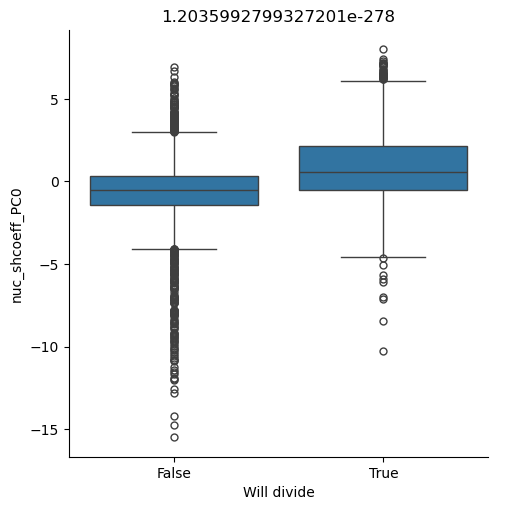

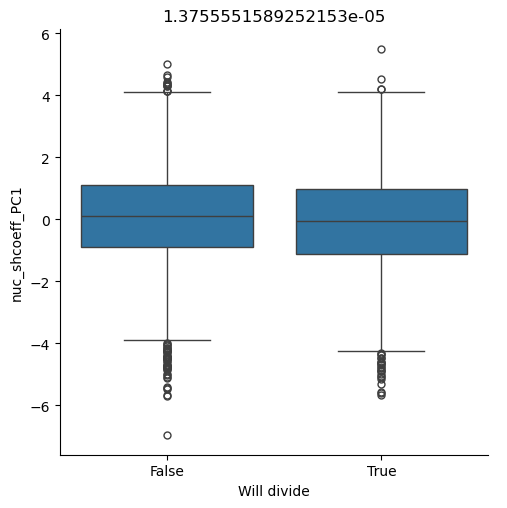

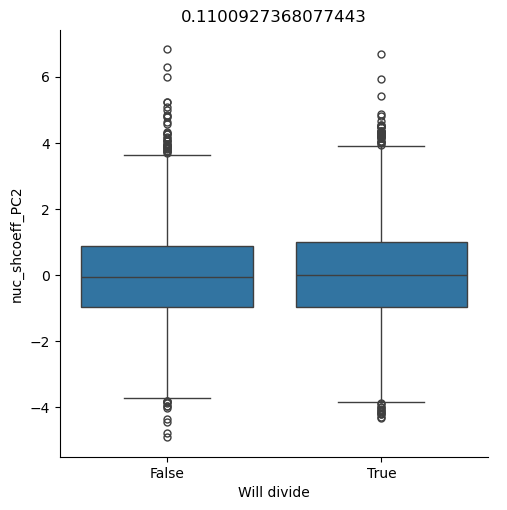

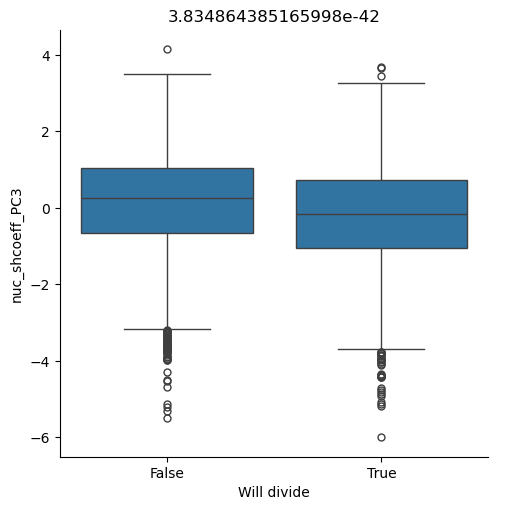

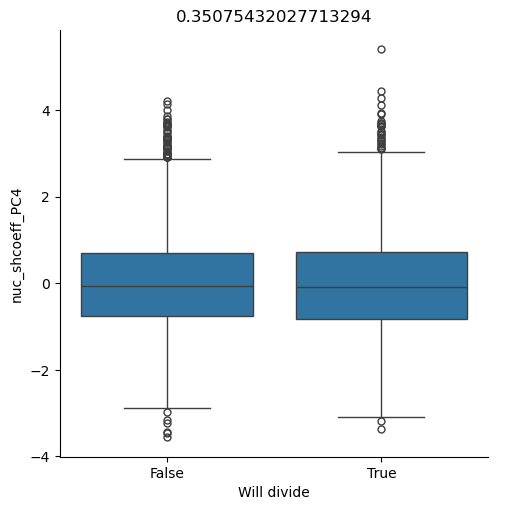

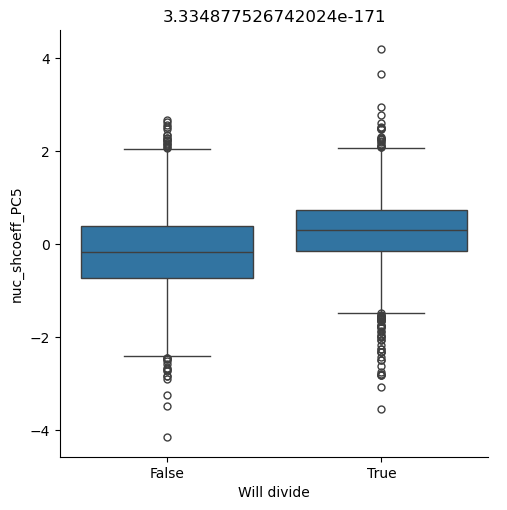

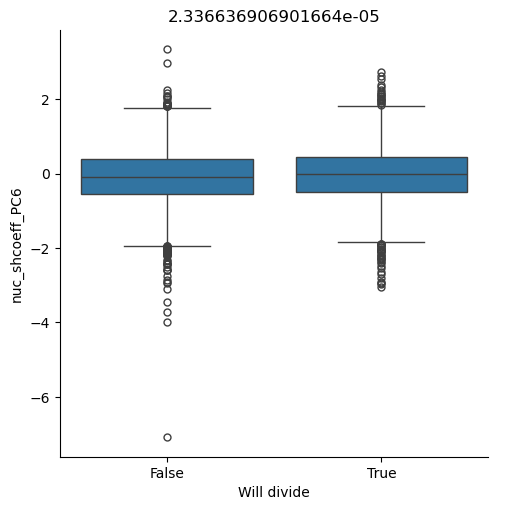

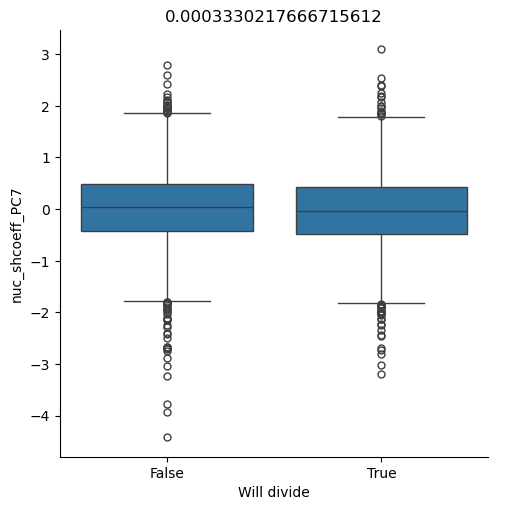

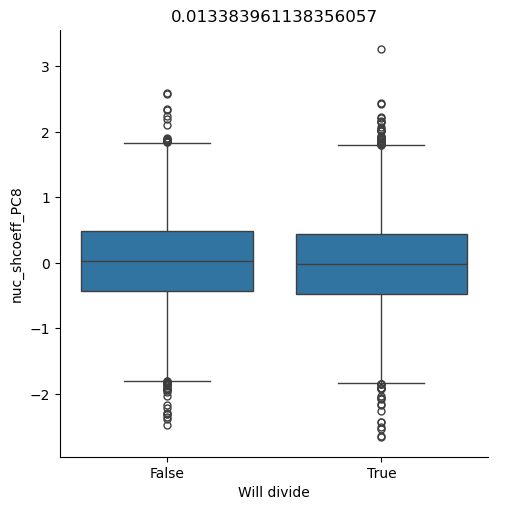

In [220]:
from basicUtils import ttest_from_groupby
# sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='nuc_shcoeff_PC6')
# sb.catplot(divisions.droplevel(axis=1,level=1),x='Cell cycle phase',y='nuc_shcoeff_PC0',kind='violin')
# sb.regplot(basals.droplevel(axis=1,level=1),x='Age',y='nuc_shcoeff_PC8')
for i in range(9):
    fig = sb.catplot(all_df.droplevel(axis=1,level=1),x='Will divide',y=f'nuc_shcoeff_PC{i}',kind='box')
    plt.title(ttest_from_groupby(all_df.droplevel(axis=1,level=1),field2group='Will divide',field2test=f'nuc_shcoeff_PC{i}')[1])
    fig.savefig(path.join(figure_dir,f'PCA_by_fate/PC{i}.svg'))

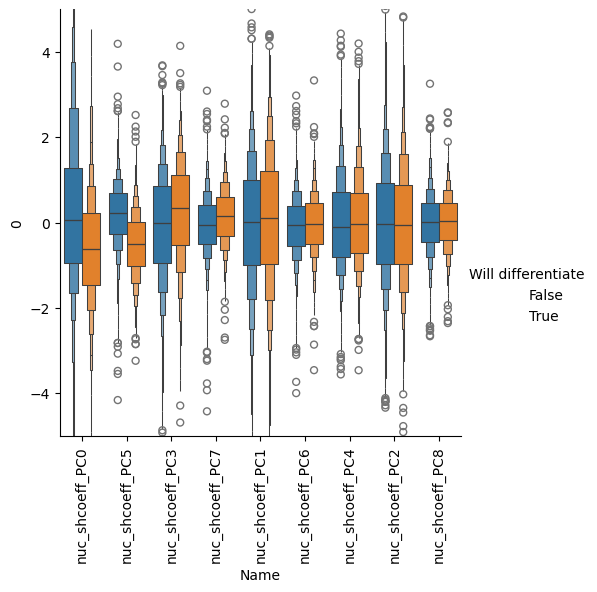

In [208]:

_diff = all_df.droplevel(axis=1,level=1).groupby('Will differentiate')[[f'nuc_shcoeff_PC{i}' for i in range(9)]].mean().diff()
order = _diff.loc[True].T.abs().sort_values(ascending=False)
fig = sb.catplot(
    all_df.droplevel(axis=1,level=1).reset_index().set_index(['Frame','TrackID','Will differentiate'])[[f'nuc_shcoeff_PC{i}' for i in range(9)]].stack().reset_index(),
    x='Name',y=0,
    kind='boxen',
   hue='Will differentiate',hue_order=[False,True],order=order.index)
plt.ylim([-5,5])
plt.xticks(rotation=90)

fig.savefig(path.join(figure_dir,'sorted_difference.svg'))

<Axes: xlabel='nuc_shcoeff_PC0', ylabel='Will differentiate'>

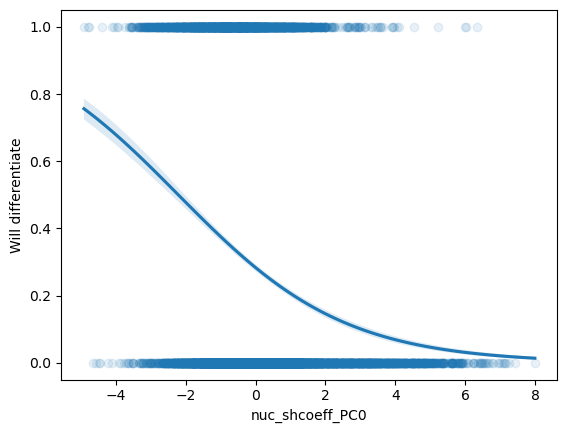

In [176]:
plt.close('all')
plt.figure()
sb.regplot(basals.droplevel(axis=1,level=1),
          x='nuc_shcoeff_PC0',y='Will differentiate',logistic=True,
         scatter_kws={'alpha':0.1})

# Average diff v. division

In [194]:
born_and_divide = {trackID:track for trackID,track in basals.reset_index().droplevel(axis=1,level=1).groupby('TrackID')
             if track.iloc[0]['Born'] and track.iloc[0]['Will divide']}
born_and_diff = {trackID:track for trackID,track in basals.droplevel(axis=1,level=1).reset_index().groupby('TrackID')
             if track.iloc[0]['Born'] and track.iloc[0]['Will differentiate']}

len(born_and_divide)
len(born_and_diff)


431

In [71]:
def get_cellID(df,trackID):
    return df.swaplevel(axis=0).loc[trackID,:]

from matplotlib.colors import Normalize
from matplotlib import colormaps,cm
def plot_cell_movement(df,t='Frame',x='X',y='Y',cmap='hot',alpha=0.5,plot_scatter=False,colorbar=False):
    
    df = df.sort_values('Frame')
    #calculate displacements
    X = df[x]
    Y = df[y]
    t = df.reset_index()[t].values
    t = t - t[0]
    
    dX = np.diff(X.values)
    dX = np.pad(dX,(0,1),constant_values=np.nan)
    dY = np.diff(Y.values)
    dY = np.pad(dY,(0,1),constant_values=np.nan)

    norm = Normalize(vmin=0,vmax=150,clip=True)
    cmap = colormaps[cmap]
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    
    plt.axis('equal')
    if plot_scatter:
        plt.scatter(X,Y,color=color)
        
    plt.quiver(X,Y,dX,dY,
               color=cmap(norm(t[1:])),
               alpha=alpha, scale=1, units='xy',headwidth=2)
    
    if colorbar:
        plt.colorbar(sm,ax=plt.gca())
    return


## Cell cycle phase

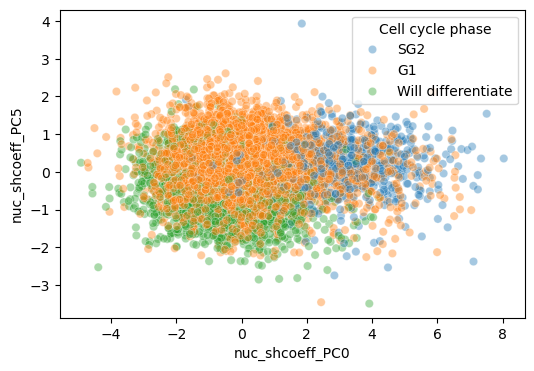

In [113]:
x = 'nuc_shcoeff_PC0'
y = 'nuc_shcoeff_PC5'

fig = plt.figure(figsize=(6,4))
phase_known = basals[basals['Cell cycle phase','Meta'] != 'NA'].droplevel(axis=1,level=1)
phase_known.loc[phase_known['Will differentiate'],'Cell cycle phase'] = 'Will differentiate'
sb.scatterplot(phase_known,x=x,y=y,alpha=0.4,hue='Cell cycle phase')
age_avg = pd.DataFrame.from_dict({age:_df[[x,y]].mean() for age,_df in pd.concat(born_and_divide.values()).groupby('Cell cycle phase')
                                 if len(_df) > 10}).T


In [73]:
plt.rcParams['svg.fonttype'] = 'none'


## Diff v. divide

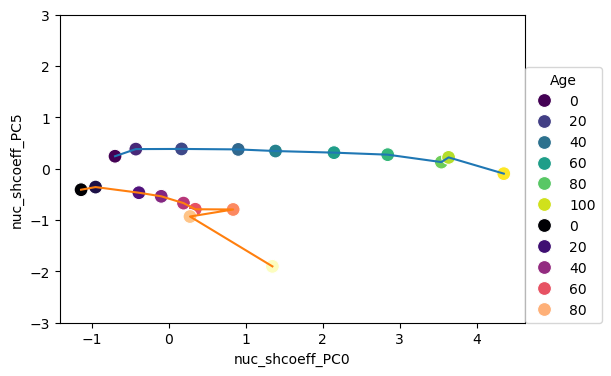

In [218]:
x = 'nuc_shcoeff_PC0'
y = 'nuc_shcoeff_PC5'

fig = plt.figure(figsize=(6,4))
# sb.scatterplot(basals.droplevel(axis=1,level=1),x=x,y=y,alpha=0.01,color='k')
age_avg = pd.DataFrame.from_dict({age:_df[[x,y]].mean() for age,_df in pd.concat(born_and_divide.values()).groupby('Age')
                                 if len(_df) > 10}).T
age_avg.index.name = 'Age'
sb.scatterplot(age_avg.reset_index(),x=x,y=y,hue='Age',palette='viridis',s=100)
plt.plot(age_avg.reset_index()[x],age_avg.reset_index()[y])

age_avg = pd.DataFrame.from_dict({age:_df[[x,y]].mean() for age,_df in pd.concat(born_and_diff.values()).groupby('Age')
                                 if len(_df) > 2}).T
age_avg.index.name = 'Age'
sb.scatterplot(age_avg.reset_index(),x=x,y=y,hue='Age',palette='magma',s=100)
plt.plot(age_avg.reset_index()[x],age_avg.reset_index()[y])
# plt.axis('equal')
plt.ylim([-3,3])
fig.savefig(path.join(figure_dir,'PC0v5_trajectory.svg'))
sb.move_legend(plt.gca(),(1,0))

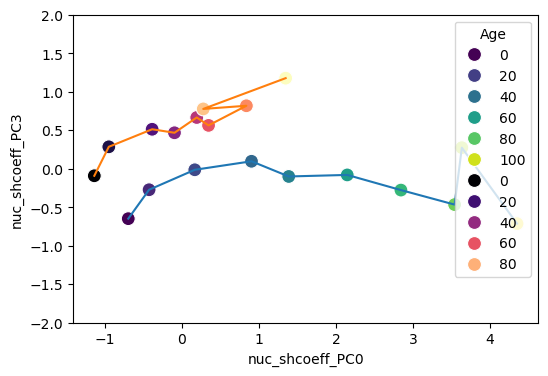

In [217]:
x = 'nuc_shcoeff_PC0'
y = 'nuc_shcoeff_PC3'

fig = plt.figure(figsize=(6,4))
# sb.scatterplot(basals.droplevel(axis=1,level=1),x=x,y=y,alpha=0.01,color='k')
age_avg = pd.DataFrame.from_dict({age:_df[[x,y]].mean() for age,_df in pd.concat(born_and_divide.values()).groupby('Age')
                                 if len(_df) > 10}).T
age_avg.index.name = 'Age'
sb.scatterplot(age_avg.reset_index(),x=x,y=y,hue='Age',palette='viridis',s=100)
plt.plot(age_avg.reset_index()[x],age_avg.reset_index()[y])

age_avg = pd.DataFrame.from_dict({age:_df[[x,y]].mean() for age,_df in pd.concat(born_and_diff.values()).groupby('Age')
                                 if len(_df) > 2}).T
age_avg.index.name = 'Age'
sb.scatterplot(age_avg.reset_index(),x=x,y=y,hue='Age',palette='magma',s=100)
plt.plot(age_avg.reset_index()[x],age_avg.reset_index()[y])
# plt.axis('equal')
plt.ylim([-2,2])
fig.savefig(path.join(figure_dir,'PC0v3_trajectory.svg'))


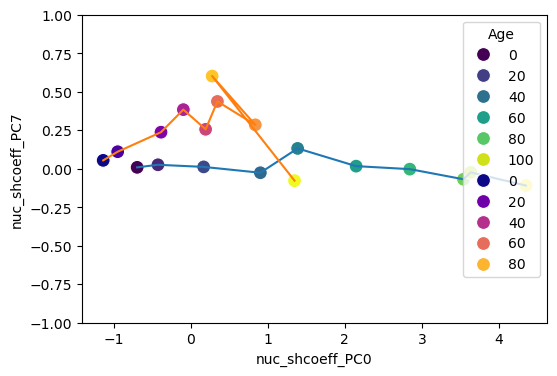

In [216]:
x = 'nuc_shcoeff_PC0'
y = 'nuc_shcoeff_PC7'

fig = plt.figure(figsize=(6,4))
# sb.scatterplot(basals.droplevel(axis=1,level=1),x=x,y=y,alpha=0.01,color='k')
age_avg = pd.DataFrame.from_dict({age:_df[[x,y]].mean() for age,_df in pd.concat(born_and_divide.values()).groupby('Age')
                                 if len(_df) > 10}).T
age_avg.index.name = 'Age'
sb.scatterplot(age_avg.reset_index(),x=x,y=y,hue='Age',palette='viridis',s=100)
plt.plot(age_avg.reset_index()[x],age_avg.reset_index()[y])

age_avg = pd.DataFrame.from_dict({age:_df[[x,y]].mean() for age,_df in pd.concat(born_and_diff.values()).groupby('Age')
                                 if len(_df) > 2}).T
age_avg.index.name = 'Age'
sb.scatterplot(age_avg.reset_index(),x=x,y=y,hue='Age',palette='plasma',s=100)
plt.plot(age_avg.reset_index()[x],age_avg.reset_index()[y])
plt.ylim([-1,1])
# plt.axis('equal')
fig.savefig(path.join(figure_dir,'PC0v7_trajectory.svg'))


## Reconstructed average cell shapes along timecourse

In [505]:
this_age

MultiIndex([( 9,   'R1_10'),
            (11, 'R1_1006'),
            ( 1, 'R1_1014'),
            (13, 'R1_1022'),
            ( 4, 'R1_1025'),
            ( 3, 'R1_1029'),
            ( 3, 'R1_1030'),
            (11, 'R1_1038'),
            (11, 'R1_1039'),
            ( 5, 'R1_1044'),
            ...
            ( 9,  'R2_921'),
            ( 1,  'R2_924'),
            ( 4,  'R2_926'),
            ( 4,  'R2_927'),
            ( 5,  'R2_929'),
            ( 6,  'R2_939'),
            ( 8,  'R2_942'),
            ( 5,   'R2_95'),
            ( 6,  'R2_957'),
            ( 7,  'R2_996')],
           names=['Frame', 'TrackID'], length=421)

In [20]:
age_avg = {age:_df.index for age,_df in pd.concat(born_and_diff.values()).set_index(['Frame','TrackID'],drop=True).groupby('Age')}
cells = [reconstruct_mesh_from_averaged_coeffs_(age_avg[t],coefs_raw, cyto_coef_cols, nuc_coef_cols) for t in sorted(age_avg.keys()) if len(age_avg[t]) > 2]
plot_cells_side_by_side(cells,num_grid = 10)

Widget(value='<iframe src="http://localhost:51348/index.html?ui=P_0x4c347ccb0_9&reconnect=auto" class="pyvista…

In [21]:
age_avg = {age:_df.index for age,_df in pd.concat(born_and_divide.values()).set_index(['Frame','TrackID'],drop=True).groupby('Age')}
cells = [reconstruct_mesh_from_averaged_coeffs_(age_avg[t],coefs_raw, cyto_coef_cols, nuc_coef_cols) for t in sorted(age_avg.keys()) if len(age_avg[t]) > 10]
plot_cells_side_by_side(cells)
        
# cells = reconstruct_mesh_from_averaged_coeffs_(this_age,coefs_raw, cyto_coef_cols, nuc_coef_cols)
# plot_cells_side_by_side([cells])

Widget(value='<iframe src="http://localhost:51348/index.html?ui=P_0x38737eff0_10&reconnect=auto" class="pyvist…